<a href="https://www.kaggle.com/code/pegasusnathanael/detectronnathan?scriptVersionId=244856049" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import sys
import os
import yaml
import json
import random
import cv2
import zipfile

import xml.etree.ElementTree as ET
from glob import glob
from tqdm import tqdm

In [2]:
# Vérification de l'environnement
print(f"PyTorch version: {torch.__version__}, CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu124, CUDA available: True


In [3]:
# Afficher les informations de l'environnement pour le débogage
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("ATTENTION: Aucun GPU n'a été détecté. L'entraînement sera extrêmement lent.")

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU: Tesla T4


In [4]:
# Installation de la dernière version de Detectron2 depuis son dépôt Git
print("Installation de Detectron2...")
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
print("Installation de Detectron2 terminée.")

Installation de Detectron2...
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-c_fyu7n9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-c_fyu7n9
  Resolved https://github.com/facebookresearch/detectron2.git to commit 65184fc057d4fab080a98564f6b60fae0b94edc4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.4 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6438699 sha256=15e0a0c4468a15e0dfa59bd2547c65a92fe3a7e8d9e8fef1900bb5a840250921
  Stored in directory: /tmp/pip-ephem-wheel-cache-jtm3cgah/whe

In [5]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo
from IPython.display import display, Image


In [6]:
from tqdm import tqdm

In [7]:
# Paramètres du projet
MODEL_CONFIG_PATH = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 
CONFIDENCE_THRESHOLD = 0.7 
LEARNING_RATE = 0.00025    
BATCH_SIZE = 2             
NUM_ITERATIONS = 7000     # Gardez une valeur élevée pour un bon apprentissage sur les 20 classes

OUTPUT_DIR = "/kaggle/working/output"
WORKING_DIR = "/kaggle/working/"

# Noms des fichiers à exporter
MODEL_EXPORT_NAME = "model_final.pth"
CONFIG_EXPORT_NAME = "config.yaml"
CLASS_NAMES_EXPORT_NAME = "class_names.json"
ZIP_EXPORT_NAME = "model_files.zip"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(WORKING_DIR, exist_ok=True)
print(f"Le dossier de sortie est prêt : {OUTPUT_DIR}")

Le dossier de sortie est prêt : /kaggle/working/output


In [8]:
PASCAL_VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

def voc_to_coco(split, voc_dir, output_file):
    """
    Fonction pour convertir les annotations de Pascal VOC (XML) en COCO (JSON).
    
    Args:
        split (str): 'train' ou 'val'.
        voc_dir (str): Chemin vers le dossier VOC2012_train_val.
        output_file (str): Chemin où sauvegarder le fichier JSON de sortie.
    """
    images_dir = os.path.join(voc_dir, "JPEGImages")
    annotations_dir = os.path.join(voc_dir, "Annotations")
    split_file = os.path.join(voc_dir, f"ImageSets/Main/{split}.txt")
    
    with open(split_file) as f:
        image_ids = [line.strip() for line in f.readlines()]
        
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    
    for i, class_name in enumerate(PASCAL_VOC_CLASSES):
        coco_output["categories"].append({"id": i, "name": class_name})
        
    annotation_id = 1
    image_id_map = {}
    
    print(f"Conversion du split '{split}'...")
    for i, image_name in enumerate(tqdm(image_ids)):
        image_path = os.path.join(images_dir, f"{image_name}.jpg")
        xml_path = os.path.join(annotations_dir, f"{image_name}.xml")
        
        # Ignorer si l'image ou l'annotation n'existe pas
        if not os.path.exists(image_path) or not os.path.exists(xml_path):
            continue
            
        img = cv2.imread(image_path)
        height, width = img.shape[:2]
        
        image_info = {
            "id": i,
            "file_name": image_path,
            "height": height,
            "width": width
        }
        coco_output["images"].append(image_info)
        image_id_map[image_name] = i
        
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        for obj in root.findall("object"):
            # Ignorer les objets difficiles ou tronqués
            if obj.find("difficult") is not None and int(obj.find("difficult").text) == 1:
                continue
            
            class_name = obj.find("name").text
            if class_name not in PASCAL_VOC_CLASSES:
                continue
            category_id = PASCAL_VOC_CLASSES.index(class_name)
            
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)
            
            bbox_width = xmax - xmin
            bbox_height = ymax - ymin
            
            annotation_info = {
                "id": annotation_id,
                "image_id": i,
                "category_id": category_id,
                "bbox": [xmin, ymin, bbox_width, bbox_height],
                "area": bbox_width * bbox_height,
                "iscrowd": 0,
                "segmentation": [] # Pas de segmentation pour cette tâche
            }
            coco_output["annotations"].append(annotation_info)
            annotation_id += 1
            
    with open(output_file, 'w') as f:
        json.dump(coco_output, f)
    print(f"Conversion terminée. Fichier sauvegardé dans {output_file}")

In [9]:
# Chemins du dataset original
voc_dir = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val"
# Chemins pour nos fichiers JSON convertis
train_json_path = os.path.join(WORKING_DIR, "train.json")
val_json_path = os.path.join(WORKING_DIR, "val.json")

# Lancer la conversion (uniquement si les fichiers n'existent pas déjà)
if not os.path.exists(train_json_path):
    voc_to_coco("train", voc_dir, train_json_path)
else:
    print(f"Le fichier {train_json_path} existe déjà. Conversion ignorée.")
    
if not os.path.exists(val_json_path):
    voc_to_coco("val", voc_dir, val_json_path)
else:
    print(f"Le fichier {val_json_path} existe déjà. Conversion ignorée.")

Conversion du split 'train'...


100%|██████████| 5717/5717 [01:49<00:00, 52.09it/s]


Conversion terminée. Fichier sauvegardé dans /kaggle/working/train.json
Conversion du split 'val'...


100%|██████████| 5823/5823 [01:54<00:00, 51.02it/s]


Conversion terminée. Fichier sauvegardé dans /kaggle/working/val.json


# ==============================================================================
# SECTION 4: ENREGISTREMENT DU DATASET CONVERTI ET FINE-TUNING
# ==============================================================================
# Cette section est maintenant très similaire à la précédente, mais utilise les fichiers que nous venons de créer.

In [10]:
# 1. Enregistrer les instances dans Detectron2
print("\nEnregistrement du dataset converti au format COCO...")
images_base_path = os.path.join(voc_dir, "JPEGImages")

# L'enregistrement se fait ici
register_coco_instances("voc_2012_train_coco", {}, train_json_path, images_base_path)
register_coco_instances("voc_2012_val_coco", {}, val_json_path, images_base_path)
print("Enregistrement terminé.")


Enregistrement du dataset converti au format COCO...
Enregistrement terminé.


In [11]:
# --- Solution 2 : Redirection de la sortie (recommandée) ---
import os
import sys

# 2. Extraire les métadonnées pour vérification
dataset_train_name = "voc_2012_train_coco"
dataset_val_name = "voc_2012_val_coco"

# --- LA CORRECTION EST ICI ---
# On force le chargement du dataset une première fois pour que les métadonnées soient peuplées.
print("Chargement des données pour peupler les métadonnées... (affichage masqué)")

# Sauvegarder la sortie standard actuelle
original_stdout = sys.stdout
# Rediriger la sortie vers "devnull" (l'équivalent d'une poubelle)
sys.stdout = open(os.devnull, 'w')

try:
    # Ces appels vont s'exécuter, mais leur sortie sera jetée
    DatasetCatalog.get(dataset_train_name)
    DatasetCatalog.get(dataset_val_name)
finally:
    # Restaurer la sortie standard originale, quoi qu'il arrive
    sys.stdout.close()
    sys.stdout = original_stdout

print("Chargement terminé.")

Chargement des données pour peupler les métadonnées... (affichage masqué)
Chargement terminé.


In [12]:
metadata = MetadataCatalog.get(dataset_train_name)

print(f"\nDataset chargé. Nombre de classes : {len(metadata.thing_classes)}")
print(f"Noms des classes : {metadata.thing_classes}")
assert 'person' in metadata.thing_classes, "La classe 'person' doit être dans le dataset !"


Dataset chargé. Nombre de classes : 20
Noms des classes : ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [13]:
# 3. Configuration et entraînement du modèle
print("\\nConfiguration du modèle pour le fine-tuning...")
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL_CONFIG_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_CONFIG_PATH)

# --- DATASETS ---
cfg.DATASETS.TRAIN = (dataset_train_name,)
cfg.DATASETS.TEST = (dataset_val_name,) # <- Valider sur toutes les classes

# --- SOLVER (Paramètres d'entraînement) ---
cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
cfg.SOLVER.BASE_LR = LEARNING_RATE
cfg.SOLVER.MAX_ITER = NUM_ITERATIONS 

# --- CHECKPOINTING & VALIDATION ---
cfg.SOLVER.CHECKPOINT_PERIOD = 2500 
cfg.TEST.EVAL_PERIOD = 2500        # <- Mesurer la performance sur toutes les classes

# --- MODEL ---
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(metadata.thing_classes) # <- Important: S'assure que le modèle a 20 sorties

# --- OUTPUT ---
cfg.OUTPUT_DIR = OUTPUT_DIR
cfg.SOLVER.LOG_PERIOD = 5  # Affiche le statut toutes les 5 itérations

\nConfiguration du modèle pour le fine-tuning...


In [14]:
# =================================================================
# HOOK TQDM SIMPLE ET EFFICACE
# =================================================================
from detectron2.engine.hooks import HookBase
from tqdm import tqdm
import sys # Important pour rediriger la sortie

class TqdmHook(HookBase):
    """
    Un hook qui gère UNIQUEMENT la barre de progression tqdm.
    """
    def __init__(self, max_iter):
        self._max_iter = max_iter
        self._pbar = None

    def before_train(self):
        # On dit à tqdm d'écrire sur stderr pour ne pas interférer avec les logs
        self._pbar = tqdm(total=self._max_iter, desc="Entraînement", leave=True, file=sys.stderr)

    def after_step(self):
        self._pbar.update(1)
        # On peut garder la mise à jour de la perte, c'est pratique
        try:
            latest_loss = self.trainer.storage.latest().get('total_loss', (0,0))[0]
            if latest_loss > 0:
                self._pbar.set_description(f"Entraînement (Perte: {latest_loss:.4f})")
        except:
            # Si le storage n'est pas prêt, on ignore
            pass

    def after_train(self):
        self._pbar.close()

In [15]:
# =================================================================
# TRAINER QUI AJOUTE LE HOOK TQDM
# =================================================================
from detectron2.engine import DefaultTrainer

class TrainerAvecTqdm(DefaultTrainer):
    """
    Cette classe hérite du DefaultTrainer et ajoute notre hook TqdmHook
    à la liste des hooks par défaut, sans rien supprimer.
    """
    def build_hooks(self):
        # On récupère la liste des hooks par défaut (y compris PeriodicWriter)
        hooks = super().build_hooks()
        
        # On ajoute simplement notre hook Tqdm à la liste existante
        hooks.insert(0, TqdmHook(self.max_iter))
        
        return hooks

In [16]:
# --- CELLULE D'ENTRAÎNEMENT (Version finale) ---

# Définir la période de log
cfg.SOLVER.LOG_PERIOD = 70 # Gardez une valeur comme 50 ou 70

print(f"Début du fine-tuning pour {cfg.SOLVER.MAX_ITER} itérations...")

# Utiliser notre trainer qui ajoute le hook
trainer = TrainerAvecTqdm(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

print("Entraînement terminé avec succès.")

Début du fine-tuning pour 7000 itérations...


model_final_280758.pkl: 167MB [00:02, 65.4MB/s]                           
Entraînement:   0%|          | 0/7000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Entraînement (Perte: 3.6741):   0%|          | 20/7000 [00:11<47:07,  2.47it/s]2025-06-11 10:41:36.992917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749638497.214052      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749638497.281998      19 cuda_blas.cc:1418] Unable to register cuBLAS factor

Entraînement terminé avec succès.


Pas de données de validation ('bbox/AP') trouvées.
Cela est normal si l'entraînement n'a pas encore atteint EVAL_PERIOD ou si l'évaluation est désactivée.


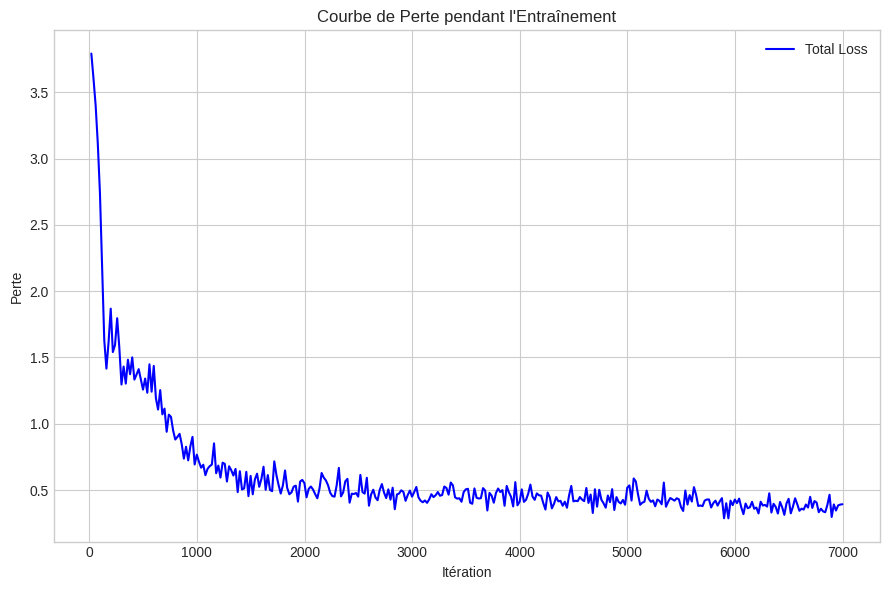

In [17]:
# --- CELLULE OPTIONNELLE : Pour visualiser manuellement les métriques (Version Robuste) ---
import json
import pandas as pd
import matplotlib.pyplot as plt
import os

# Chemin vers le fichier de métriques
metrics_path = "/kaggle/working/output/metrics.json"

# Vérifier si le fichier de métriques existe avant de continuer
if not os.path.exists(metrics_path):
    print(f"Fichier de métriques introuvable : {metrics_path}")
    print("Assurez-vous que l'entraînement a commencé et a généré des logs.")
else:
    # Charger les données (c'est un fichier JSON Lines)
    data = []
    with open(metrics_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))

    df = pd.DataFrame(data)

    # Créer les graphiques
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Déterminer si on a des données de validation
    has_validation_data = 'bbox/AP' in df.columns
    
    # Ajuster la taille de la figure en fonction des données disponibles
    num_plots = 2 if has_validation_data else 1
    fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 6), squeeze=False)
    ax1 = axes[0, 0]

    # --- Graphique de la perte totale (toujours présent) ---
    if 'total_loss' in df.columns:
        loss_df = df.dropna(subset=['total_loss'])
        ax1.plot(loss_df['iteration'], loss_df['total_loss'], label='Total Loss', color='b')
        ax1.set_title('Courbe de Perte pendant l\'Entraînement')
        ax1.set_xlabel('Itération')
        ax1.set_ylabel('Perte')
        ax1.legend()
        ax1.grid(True)
    else:
        ax1.text(0.5, 0.5, 'Pas de données de "total_loss" trouvées.', ha='center', va='center')


    # --- Graphique de la précision (uniquement si la colonne existe) ---
    if has_validation_data:
        ax2 = axes[0, 1]
        ap_df = df.dropna(subset=['bbox/AP'])
        ax2.plot(ap_df['iteration'], ap_df['bbox/AP'], label='AP (Validation)', marker='o', color='g')
        ax2.set_title('Performance de Validation (AP)')
        ax2.set_xlabel('Itération')
        ax2.set_ylabel('Average Precision (AP)')
        ax2.legend()
        ax2.grid(True)
    else:
        print("Pas de données de validation ('bbox/AP') trouvées.")
        print("Cela est normal si l'entraînement n'a pas encore atteint EVAL_PERIOD ou si l'évaluation est désactivée.")

    plt.tight_layout()
    plt.show()

# ==============================================================================
# SECTION 5: TEST DE PRÉDICTION ET EXPORTATION
# ==============================================================================
# Cette section est également identique, car le modèle est entraîné et les artefacts sont les mêmes.

In [18]:
print("\nTest de prédiction sur une image de validation...")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, MODEL_EXPORT_NAME)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = CONFIDENCE_THRESHOLD
predictor = DefaultPredictor(cfg)

val_metadata = MetadataCatalog.get(dataset_val_name)
dataset_dicts_val = DatasetCatalog.get(dataset_val_name)
# Attention: les chemins dans les dicts pointent maintenant vers les images originales
sample = random.choice(dataset_dicts_val)
im = cv2.imread(sample["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


Test de prédiction sur une image de validation...


Résultat de la prédiction :


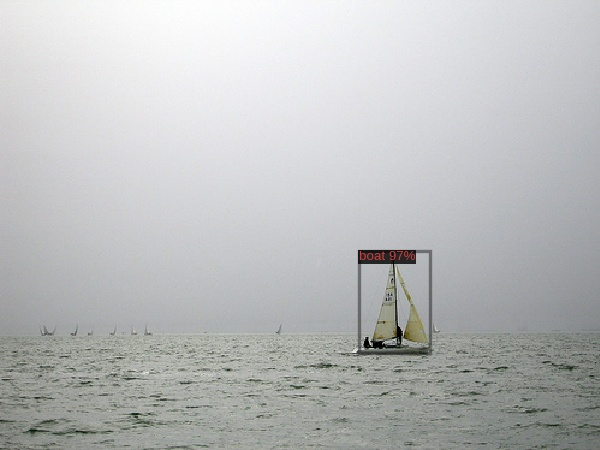

In [19]:
print("Résultat de la prédiction :")
img_bytes = cv2.imencode('.jpg', out.get_image()[:, :, ::-1])[1].tobytes()
display(Image(data=img_bytes))

In [20]:
print("\nExportation des fichiers du modèle...")
model_path = os.path.join(cfg.OUTPUT_DIR, MODEL_EXPORT_NAME)
config_path = os.path.join(cfg.OUTPUT_DIR, CONFIG_EXPORT_NAME)
with open(config_path, 'w') as f:
    f.write(cfg.dump())
    
class_names = metadata.thing_classes
class_names_path = os.path.join(cfg.OUTPUT_DIR, CLASS_NAMES_EXPORT_NAME)
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)

zip_path = os.path.join(OUTPUT_DIR, ZIP_EXPORT_NAME)
print(f"Création de l'archive ZIP : {zip_path}")
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(model_path, arcname=MODEL_EXPORT_NAME)
    zipf.write(config_path, arcname=CONFIG_EXPORT_NAME)
    zipf.write(class_names_path, arcname=CLASS_NAMES_EXPORT_NAME)

print("\n--- OPÉRATION TERMINÉE ---")
print(f"L'archive '{ZIP_EXPORT_NAME}' a été créée avec succès.")
print("Elle contient 'model_final.pth', 'config.yaml', et 'class_names.json'.")
print("Téléchargez-la depuis le panneau 'Data' -> 'Output' de Kaggle.")


Exportation des fichiers du modèle...
Création de l'archive ZIP : /kaggle/working/output/model_files.zip

--- OPÉRATION TERMINÉE ---
L'archive 'model_files.zip' a été créée avec succès.
Elle contient 'model_final.pth', 'config.yaml', et 'class_names.json'.
Téléchargez-la depuis le panneau 'Data' -> 'Output' de Kaggle.
